In [1]:
#pytorch
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models

# general
import os
from collections import defaultdict
import time
import json
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

## Загрузка данных 

In [2]:
batch_size = 4

In [3]:
data_transforms = \
{
    'train': 
    [
#         transforms.CenterCrop(224),
        transforms.Resize(300),
        transforms.CenterCrop(300),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ],
    'test': 
    [
        transforms.Resize(300),
        transforms.CenterCrop(300),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
}

In [4]:
image_datasets = {x: ImageFolder(os.path.join('img', x), transforms.Compose(data_transforms[x])) for x in ['train', 'test']}

In [5]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
dataset_sizes

{'train': 6710, 'test': 3305}

In [7]:
class_names = image_datasets['train'].classes
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Визуализация 

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    
    #revert normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

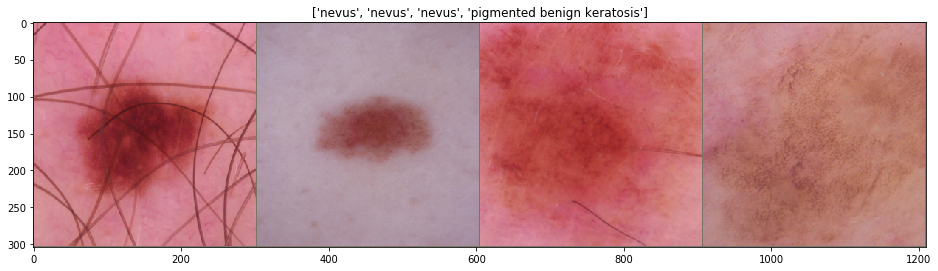

In [10]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Функции обучения и валидации


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, print_log=True):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    stat_dict = {
        "train" :{
            "epoch" : [],
            "loss" : [],
            "acc" : []
        },
        "test" :{
            "epoch" : [],
            "loss" : [],
            "acc" : []
        }
    }


    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            is_train_phase = (phase == "train")
            model.train(is_train_phase)
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(is_train_phase):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if is_train_phase:
                        loss.backward()
                        optimizer.step()

                # statistics inputs.size(0) = batch_size 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if is_train_phase:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            stat_dict[phase]["epoch"].append(epoch)
            stat_dict[phase]["loss"].append(epoch_loss)
            stat_dict[phase]["acc"].append(epoch_acc.item())
            
            if print_log:
                print(f"{phase} Loss: {epoch_loss : .4f} Acc: {epoch_acc : .4f}")
                time_elapsed = time.time() - start_time
                print(f"Time passed {time_elapsed // 60 : .0f} m {time_elapsed % 60 : .0f} s")
                
            # deep copy the model
            if (not is_train_phase) and (epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed // 60 : .0f}m {time_elapsed % 60 : .0f}s")
    print(f"Best val Acc: {best_acc : .4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, stat_dict

In [23]:
def valid_model(model, print_log=True):
    result_dict = {
        "real" : [],
        "predicted" : []
    }

    with torch.no_grad():
        for images, labels in dataloaders["test"]:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
                result_dict["real"].append(class_names[labels[i]])
                result_dict["predicted"].append(class_names[predicted[i]])

    result_df = pd.DataFrame(result_dict)
    result_df["answer"] = result_df.apply(lambda x: int(x["real"] == x["predicted"]), axis=1)

    acc_dict = {}
    total_acc = accuracy_score(result_df["real"], result_df["predicted"]) * 100
    acc_dict["total"] = total_acc
    
    if print_log:
        print(f"Total accuracy: {round(total_acc, 2)}%")

    for img_class in result_df["real"].unique():
        class_df = result_df[result_df["real"] == img_class]
        class_acc = accuracy_score(class_df["real"], class_df["predicted"]) * 100
        acc_dict[img_class] = class_acc
        if print_log:
            print(f"\t{img_class} ({len(class_df)}) : {round(class_acc, 2)}%")
    
    return acc_dict

## Обучение 

In [17]:
def convert_score_to_df(score_dict):
    data = defaultdict(list)
    first = list(score_dict.keys())[0]
    for scope in score_dict[first]:
        data["scope"].append(scope)
        for model_name in score_dict:
            data[model_name].append(round(score_dict[model_name][scope],2))
    
    df = pd.DataFrame(data)
    df = df.set_index("scope")
    df.to_csv("models_score.csv", sep=';')
    return df

In [18]:
def save_to_json(modelname, loss_dict):
    with open(f"nn_train_stat/{modelname}.json", 'w') as json_file:
        json.dump(loss_dict, json_file)

In [26]:
model_dict = {
#     "inception_v3" : models.inception_v3(pretrained=True),
    "resnet18" : models.resnet18(pretrained=True),
    "resnet50" : models.resnet50(pretrained=True)
}

In [ ]:
score_dict = {}

for model_name in model_dict:
    print('_' * 10, model_name, '_' * 10)
    model = model_dict[model_name]
    if model_name == "inception_v3":
        model.aux_logits=False
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    model, stat_dict = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25, print_log=True)
    
    save_to_json(model_name, stat_dict)
    coeff_path = f"nn_coeffs/pre_learned_no_changes_in_data/{model_name}.pth"
    torch.save(model.state_dict(), coeff_path)
    
    print()
    
    score_dict[model_name] = valid_model(model)
    
    print('\n' * 2)
    
    torch.cuda.empty_cache()
    
convert_score_to_df(score_dict)

__________ resnet18 __________
Epoch 1/25
----------
train Loss:  0.9026 Acc:  0.6993
Time passed  1m  32s
test Loss:  0.7198 Acc:  0.7470
Time passed  1m  49s

Epoch 2/25
----------
train Loss:  0.7373 Acc:  0.7495
Time passed  3m  21s
test Loss:  0.6073 Acc:  0.7818
Time passed  3m  38s

Epoch 3/25
----------
train Loss:  0.6469 Acc:  0.7753
Time passed  5m  10s
test Loss:  0.5816 Acc:  0.7876
Time passed  5m  27s

Epoch 4/25
----------
train Loss:  0.5888 Acc:  0.7933
Time passed  6m  59s
test Loss:  0.5081 Acc:  0.8133
Time passed  7m  16s

Epoch 5/25
----------
train Loss:  0.5257 Acc:  0.8180
Time passed  8m  48s
test Loss:  0.6655 Acc:  0.7734
Time passed  9m  5s

Epoch 6/25
----------
train Loss:  0.4726 Acc:  0.8347
Time passed  10m  37s
test Loss:  0.6045 Acc:  0.7970
Time passed  10m  54s

Epoch 7/25
----------
train Loss:  0.4469 Acc:  0.8446
Time passed  12m  27s
test Loss:  0.5755 Acc:  0.8054
Time passed  12m  43s

Epoch 8/25
----------
train Loss:  0.2843 Acc:  0.9072
T